<p style="background-color:#blue;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid black;">Natural Language Processing with Disaster Tweets<span style='font-size:28px; background-color:blue ;'></span></p>


<center><img src="https://github.com/Isharaneranjana/kaggle_gif/blob/main/NLP%20WITH%20DISASTER%20TWEETS.gif?raw=true"></center>

## <p style="background-color:#FC7D77;color:black;font-size:20px;text-align:center;border-radius:10px 10px;"> Introduction 🎯</p>
<font size="4">Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter. In this notebook, I am going to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. The dataset consists of 10,000 tweets that were hand classified. </font>


In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install tokenization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import gc
import re
import string
import operator
from collections import defaultdict
import tokenization
from wordcloud import STOPWORDS

In [4]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test=  pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


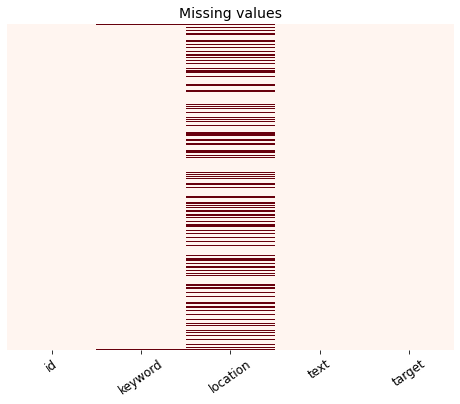

In [6]:
plt.figure(figsize = (8, 6))
sns.heatmap(train.isna(), yticklabels = False, cbar = False, cmap = 'Reds')
plt.title("Missing values", fontsize = 14)
plt.xticks(rotation = 35, fontsize = 12)
plt.show()

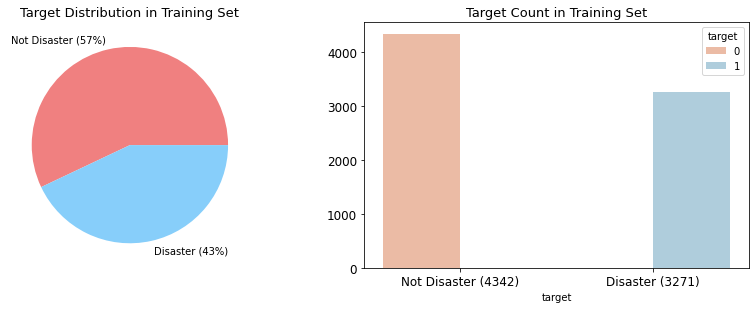

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'],colors=['lightcoral','lightskyblue'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1], palette="RdBu")

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

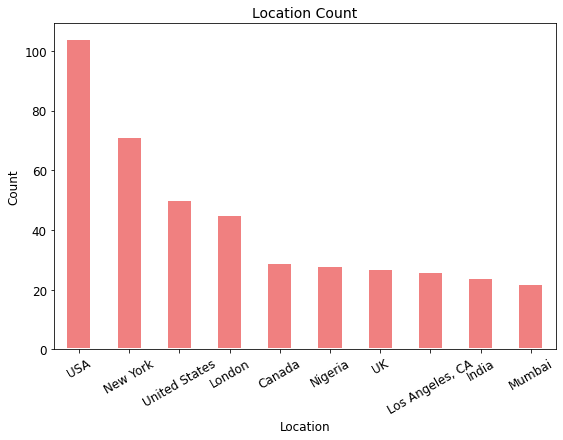

In [8]:
plt.figure(figsize = (9, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax = ((train.location.value_counts())[:10]).plot(kind = 'bar', color = 'lightcoral', linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
ax.xaxis.set_tick_params(labelsize = 12, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 12)


In [9]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50
DISASTER_TWEETS = train['target'] == 1
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

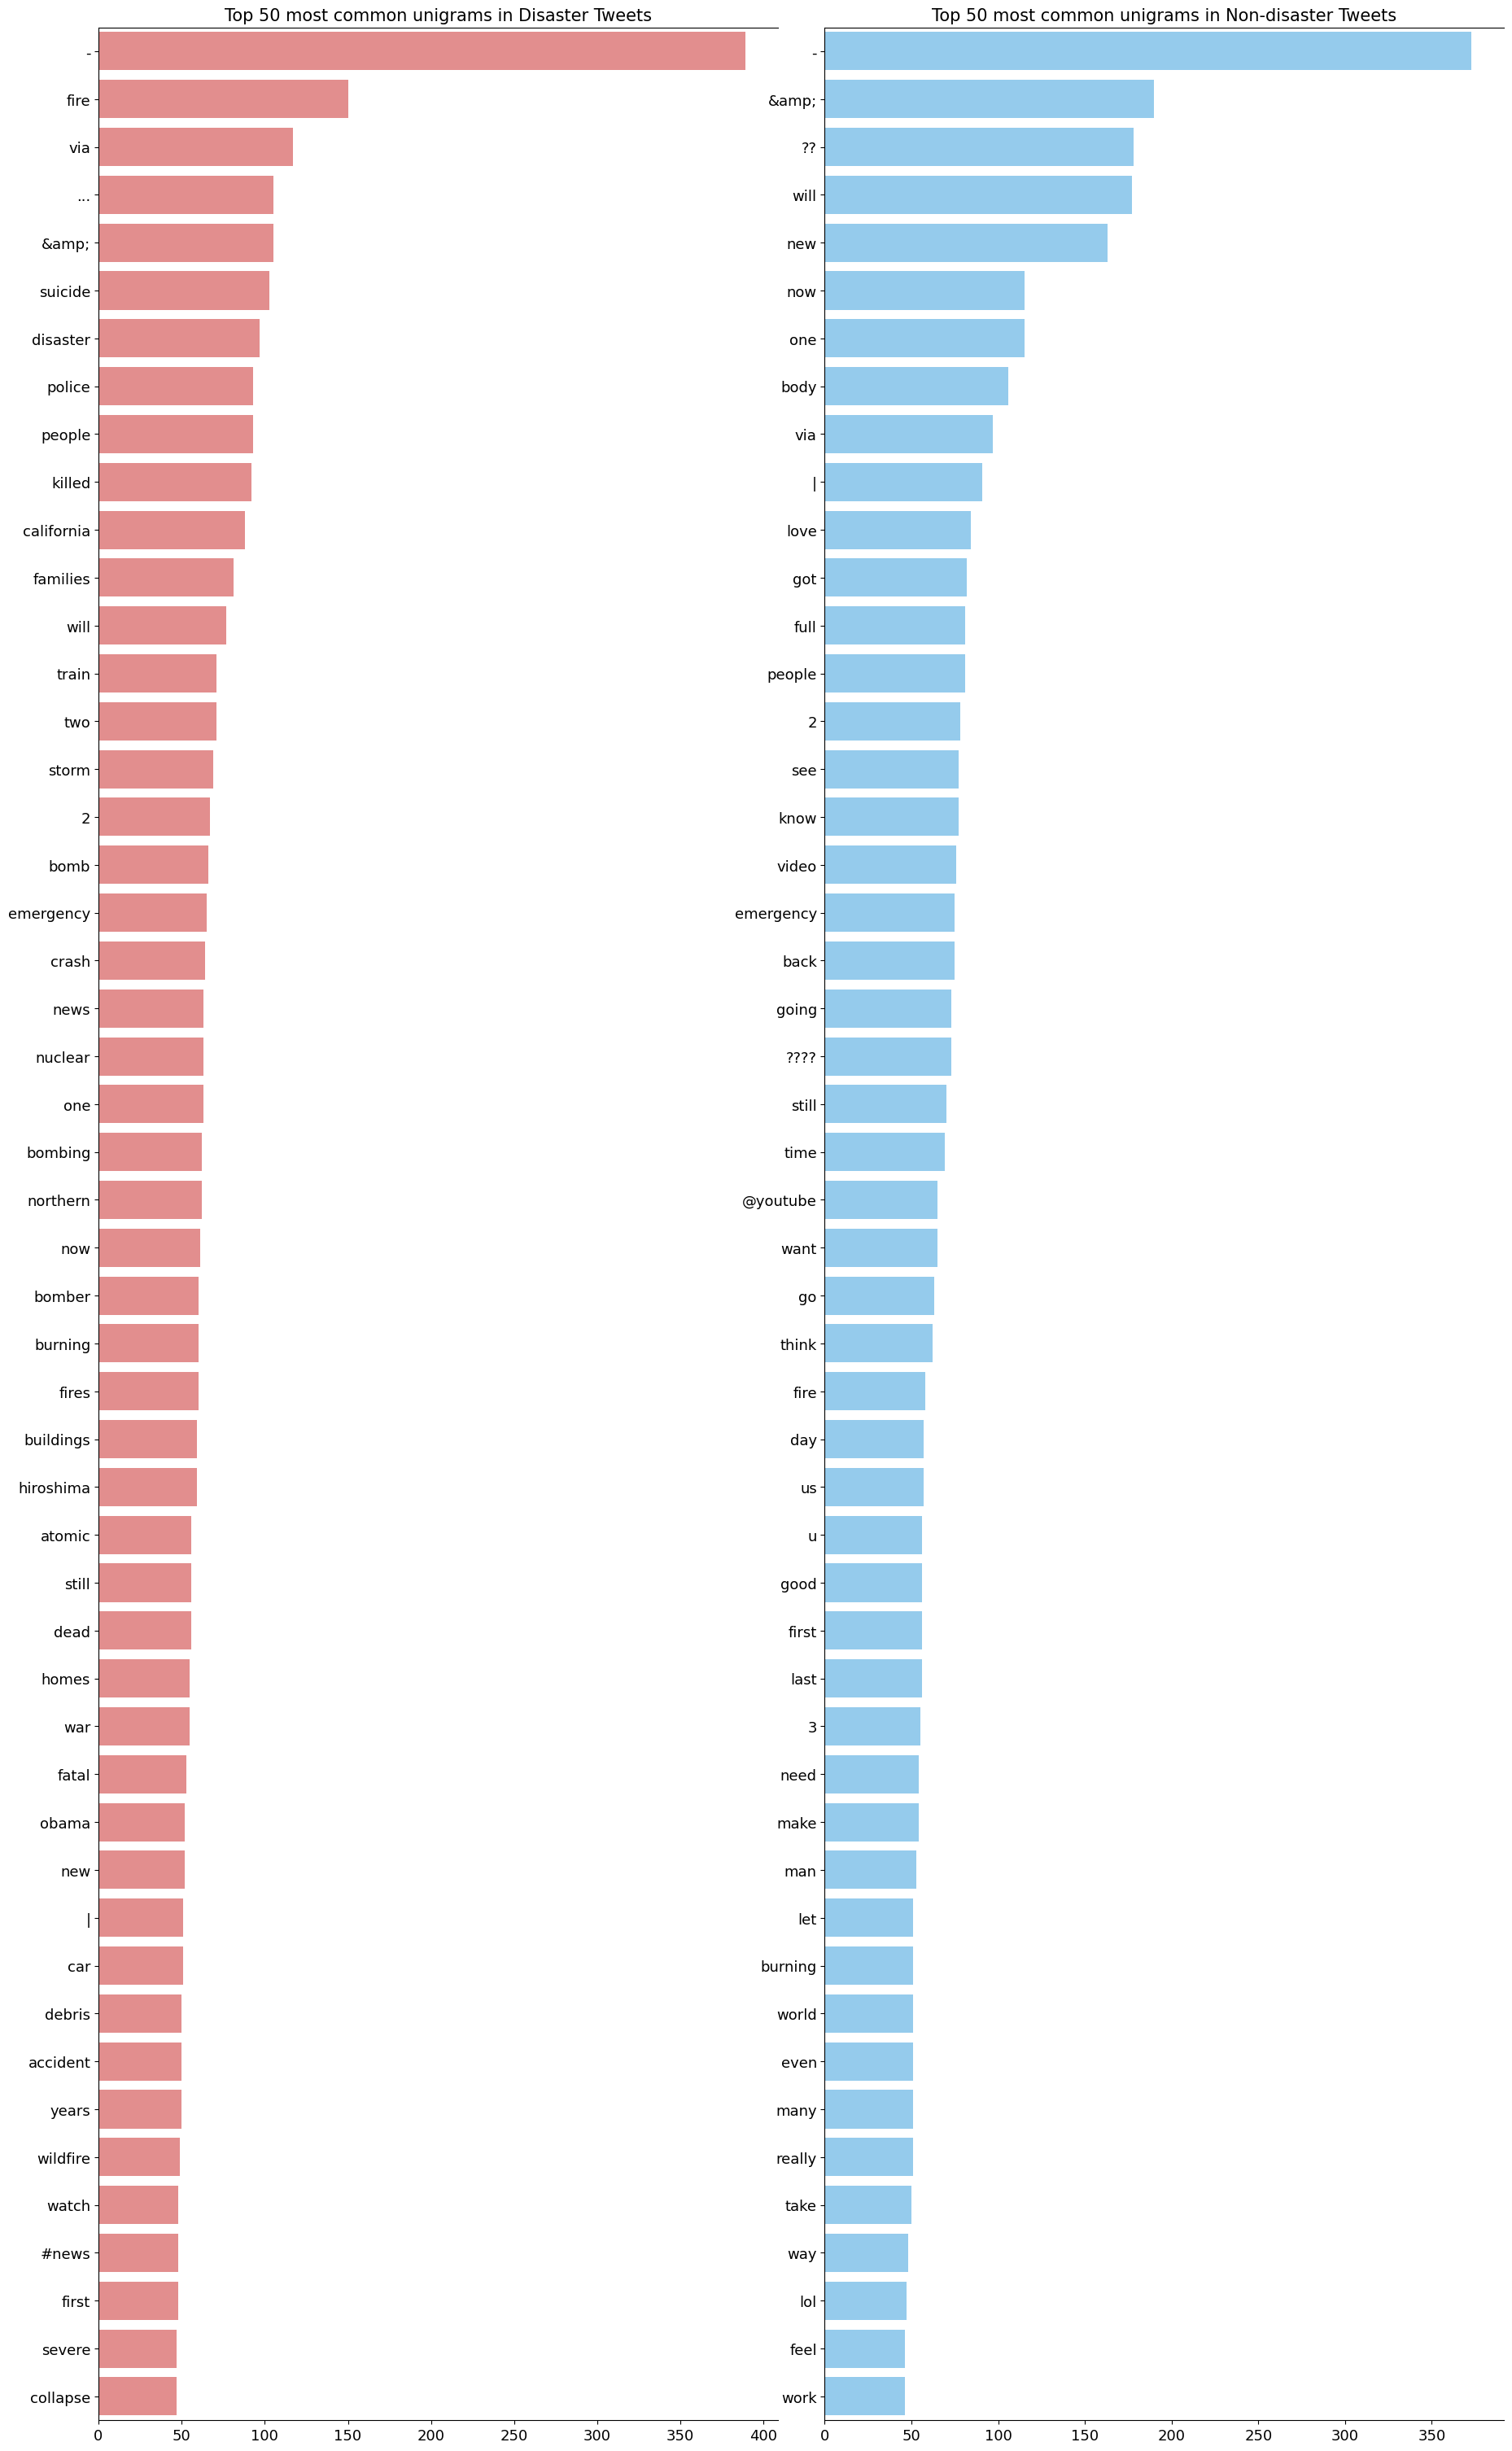

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


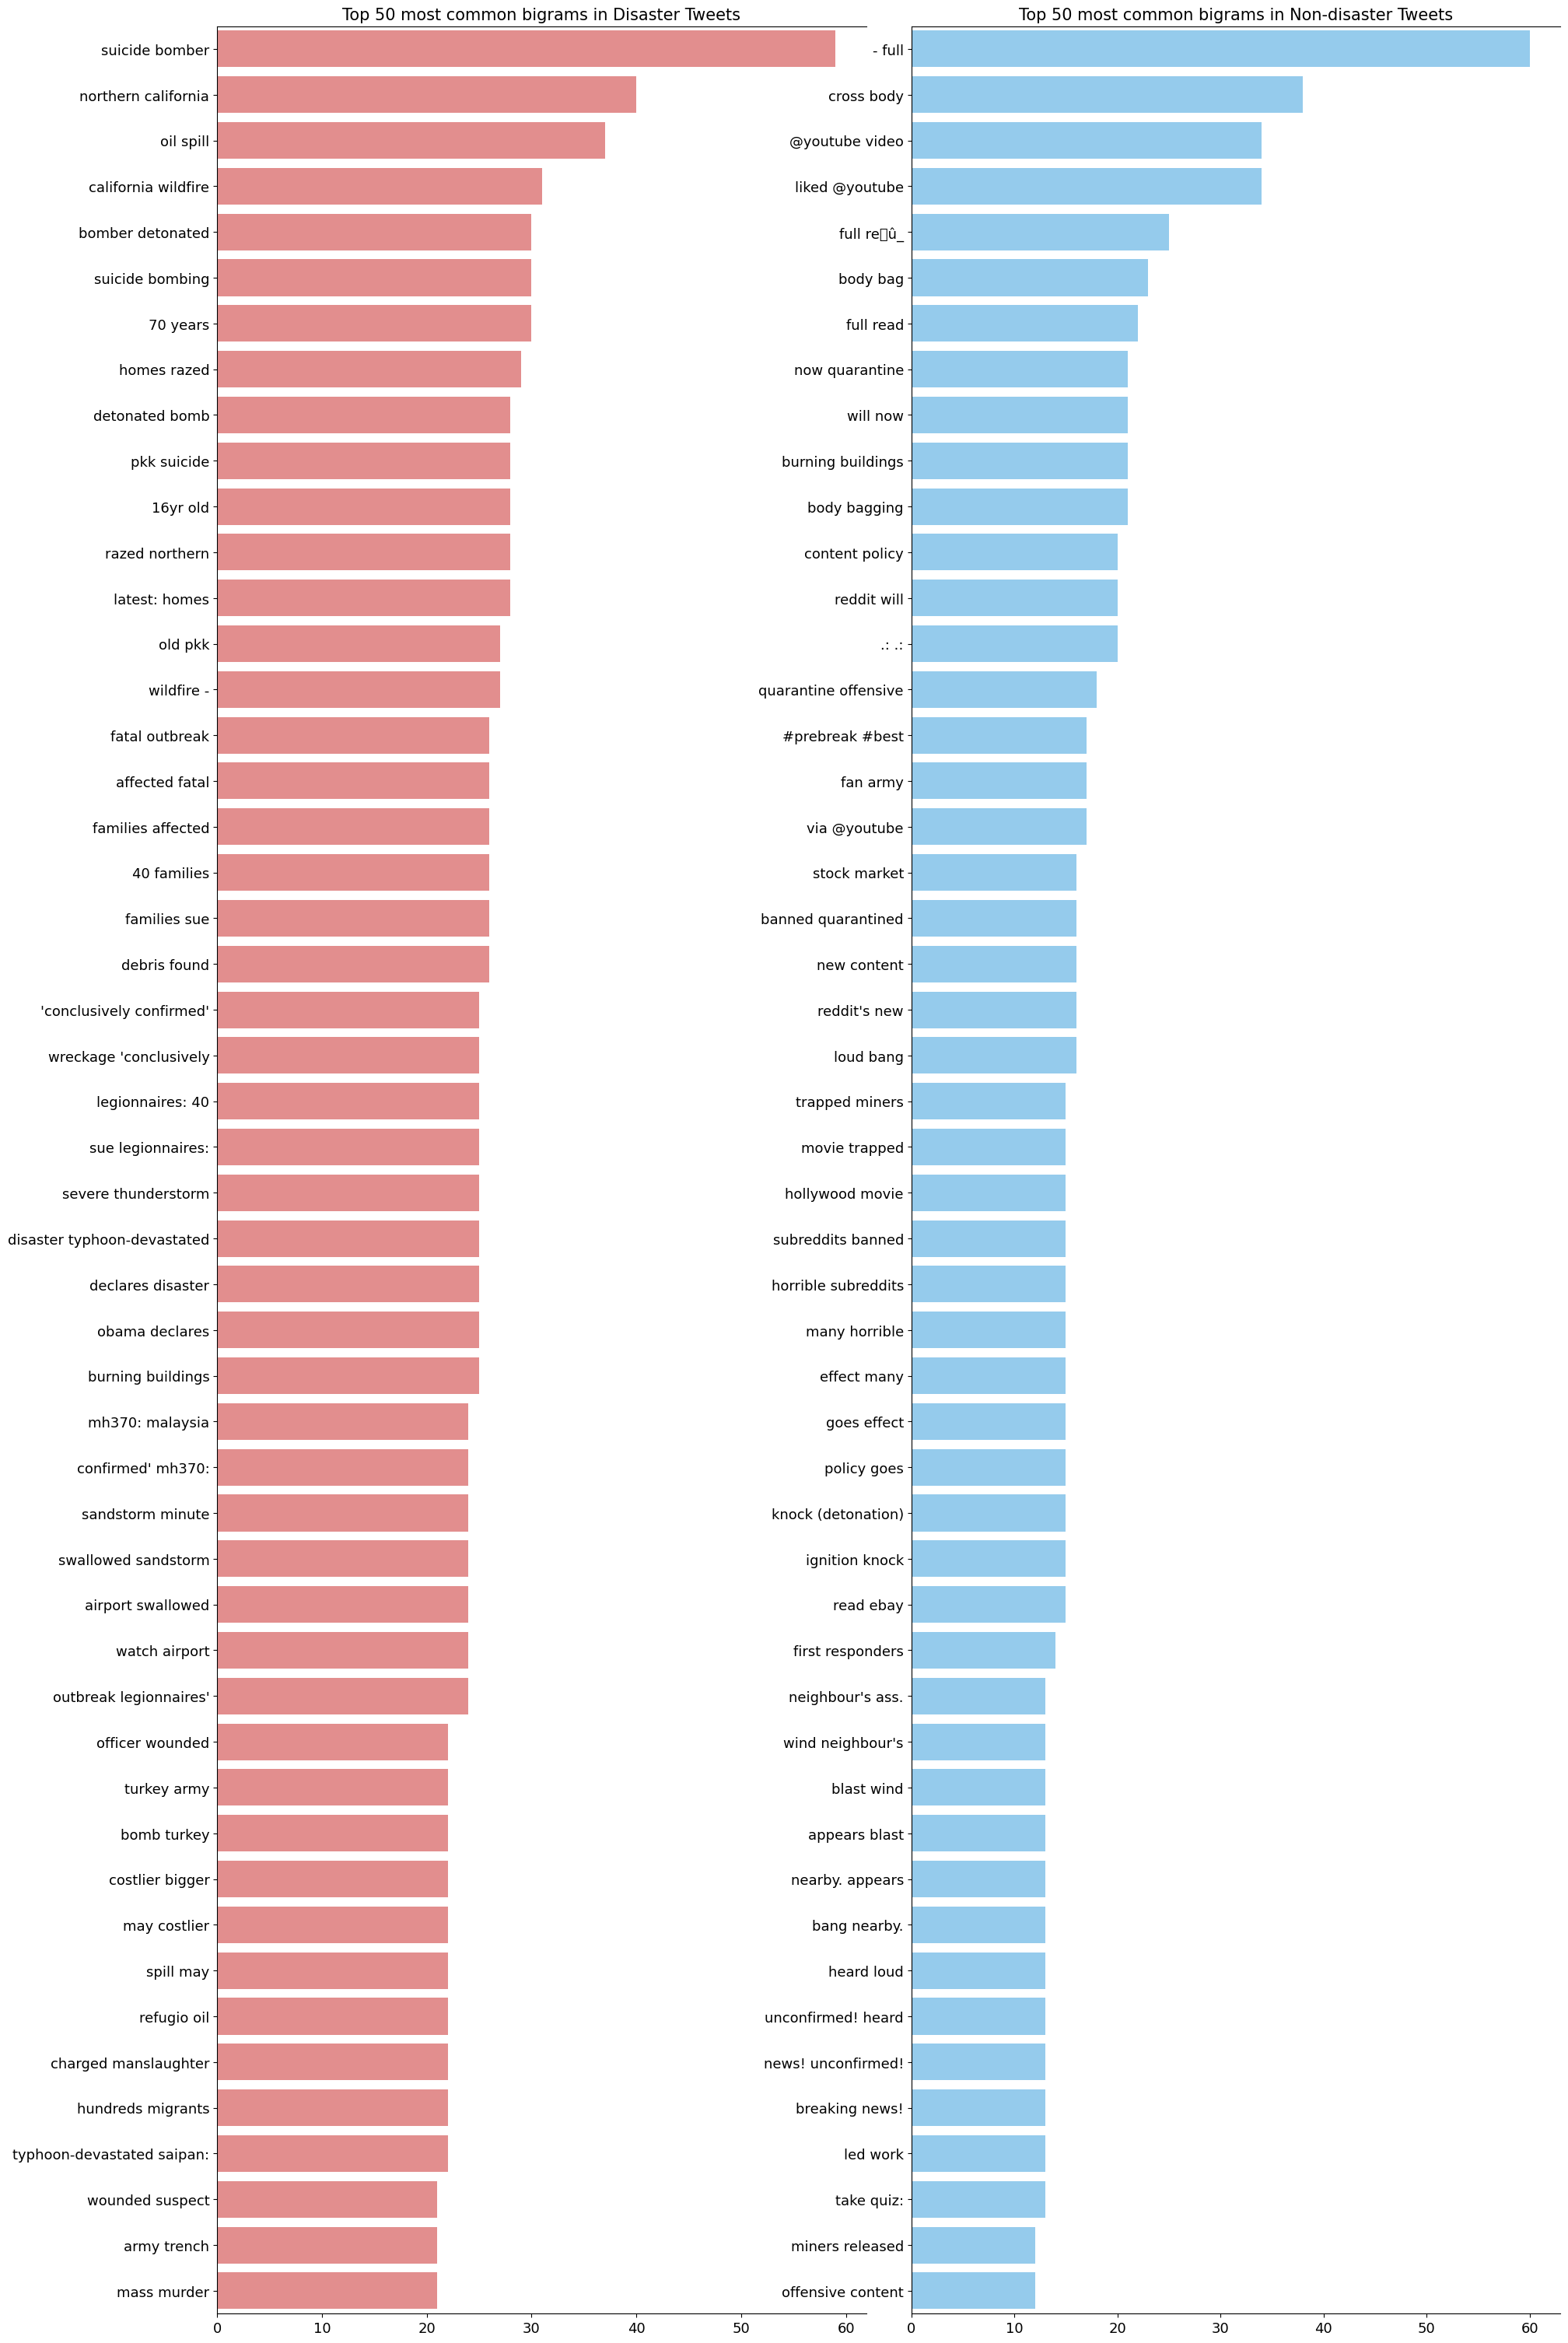

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(18,30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


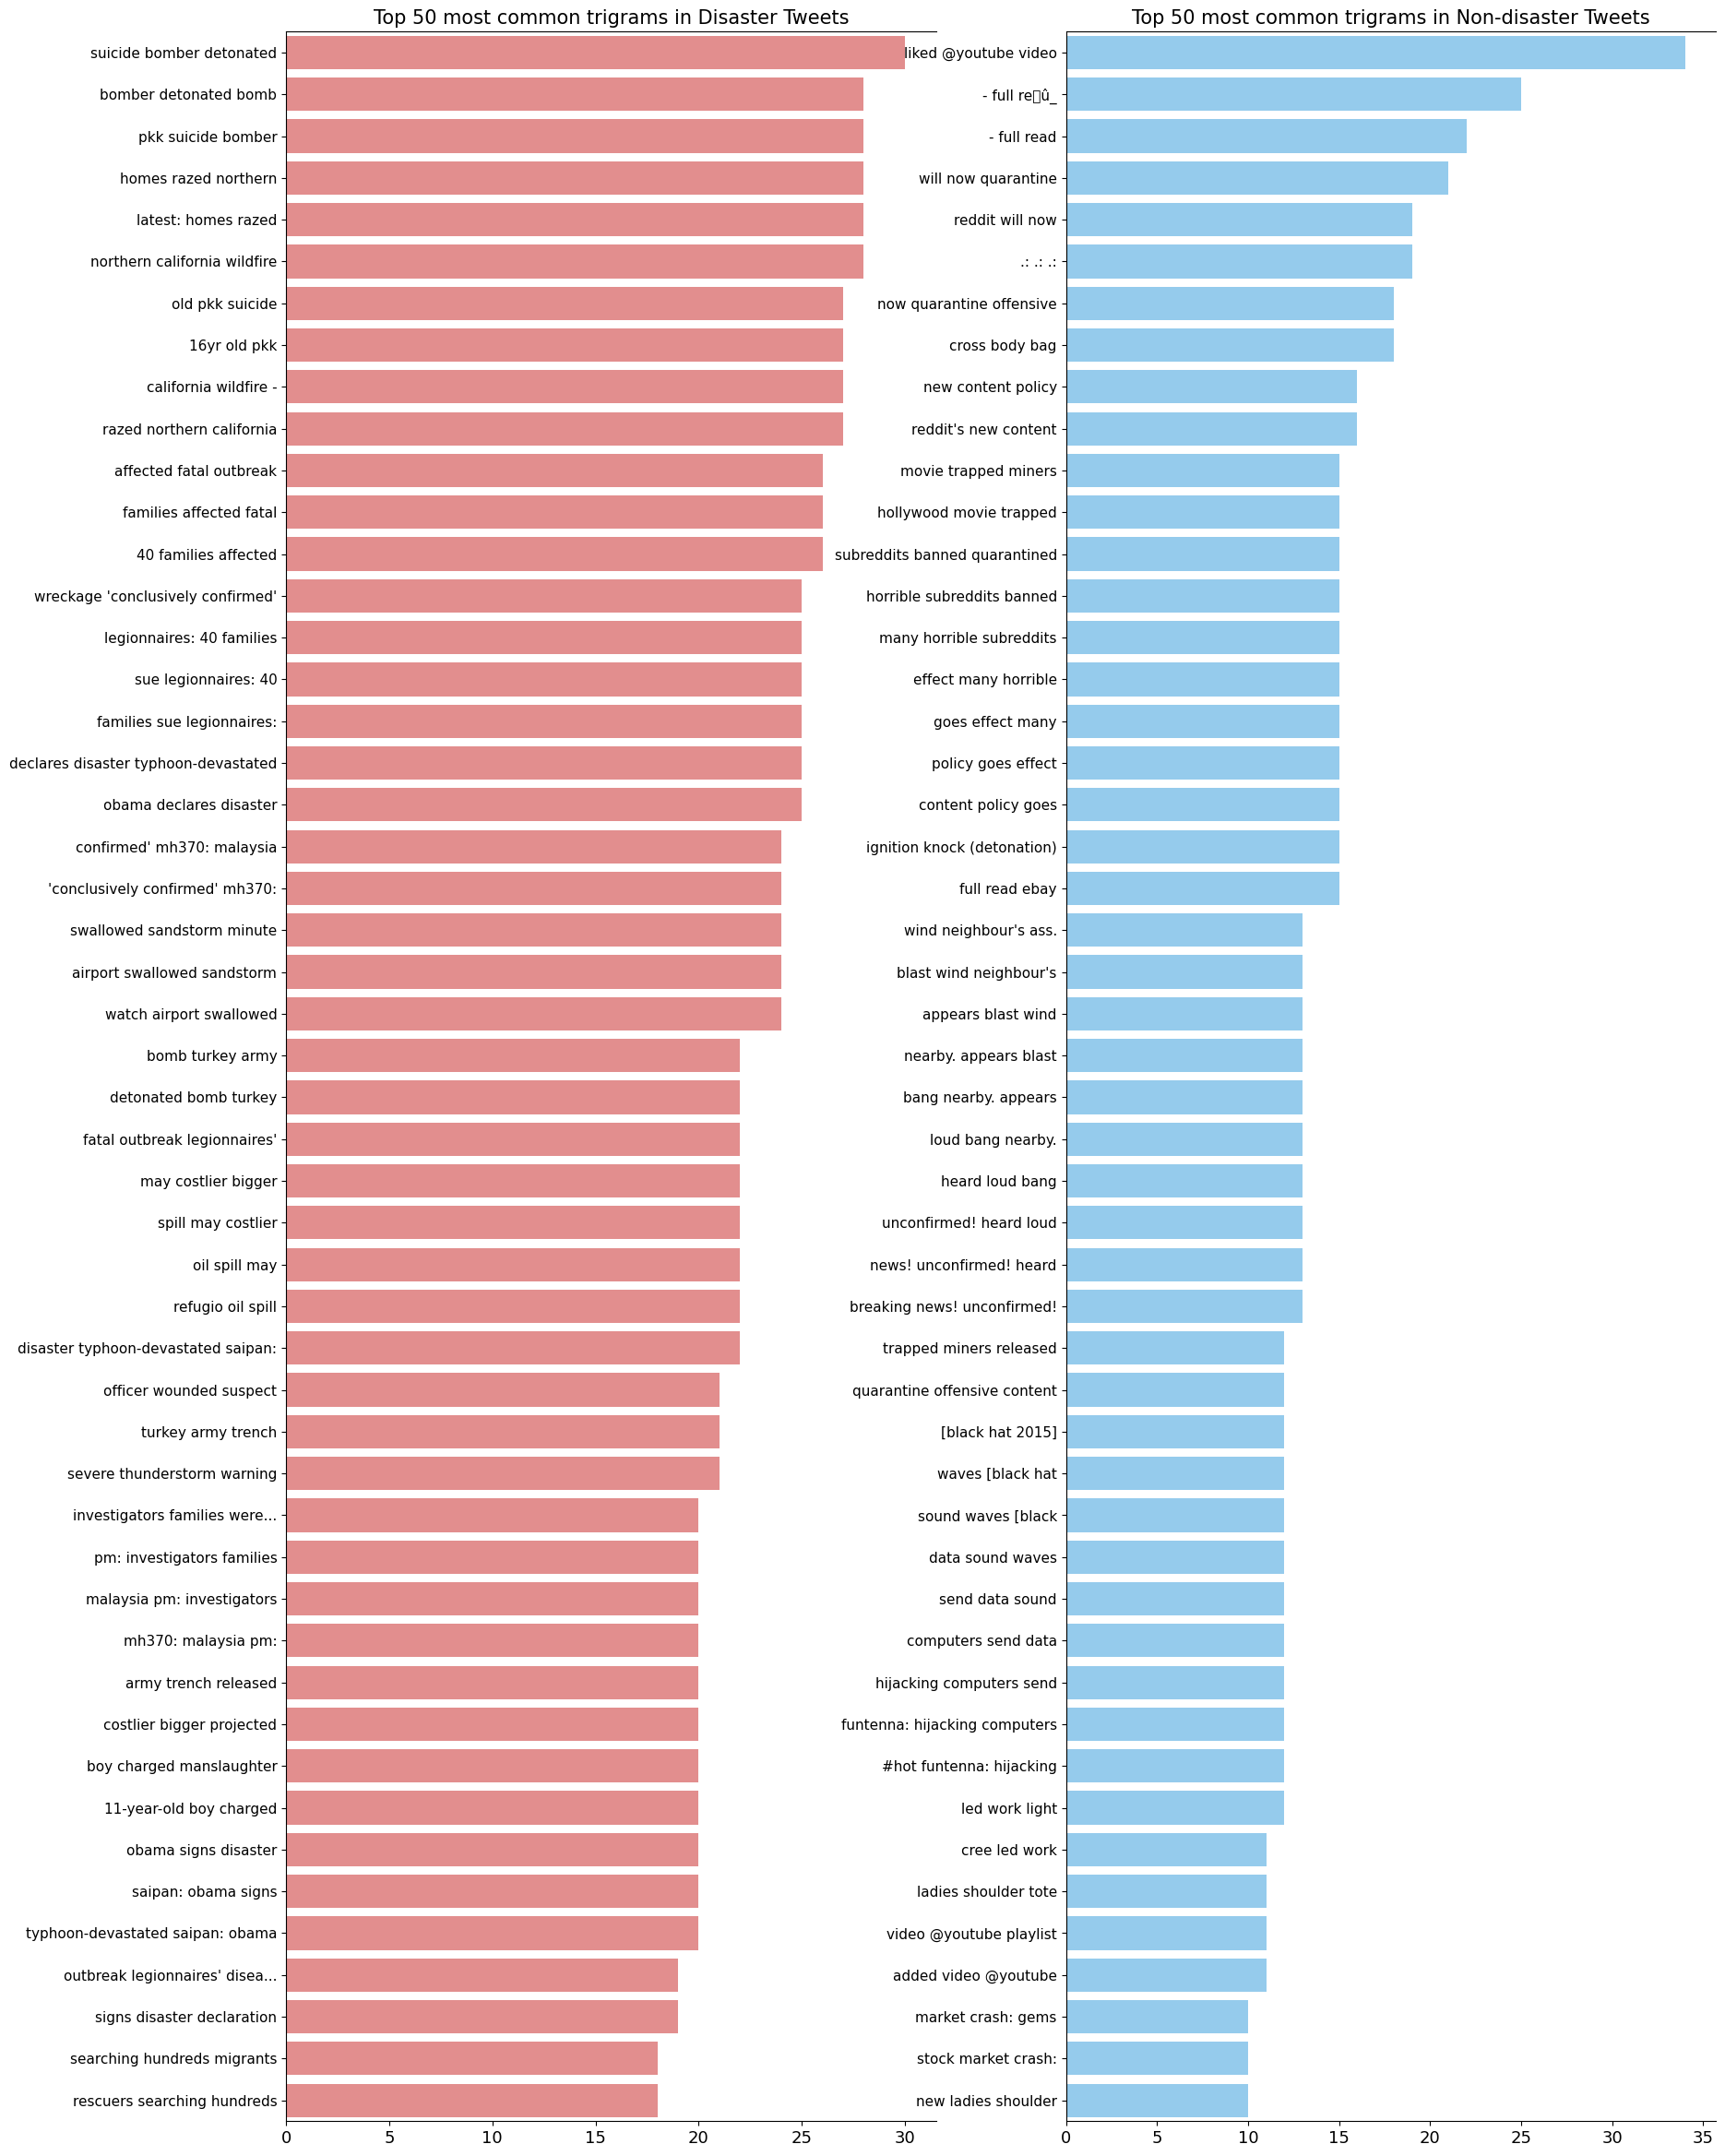

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 30), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [13]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

new_df = pd.DataFrame()
new_df['location'] = ((train['location'].value_counts())[:10]).index
new_df['count'] = ((train['location'].value_counts())[:10]).values
geolocator = Nominatim(user_agent = 'Rahil')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 0.5)
lat = {}
long = {}
for i in new_df['location']:
    location = geocode(i)
    lat[i] = location.latitude
    long[i] = location.longitude
new_df['latitude'] = new_df['location'].map(lat)
new_df['longitude'] = new_df['location'].map(long)
map = folium.Map(location = [10.0, 10.0], tiles = 'CartoDB dark_matter', zoom_start = 1.5)
markers = []
title = '''<h1 align = "center" style = "font-size: 15px"><b>Top 10 Tweet Locations</b></h1>'''
for i, r in new_df.iterrows():
    loss = r['count']
    if r['count'] > 0:
        counts = r['count'] * 0.4
        folium.CircleMarker([float(r['latitude']), float(r['longitude'])], radius = float(counts), color = 'lightcoral', fill = True).add_to(map)
map.get_root().html.add_child(folium.Element(title))
map

In [14]:
df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

### data cleaning

In [15]:
#drop the id column since it does not contain any valuable information
train=train.drop(['id','keyword','location'],1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [16]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
len(train)

7613

In [18]:
from nltk import FreqDist
import nltk

train.reset_index(drop=True)
#tokenizes the sentences and convert it to the lowercase and add those values to the list corpus
corpus=[]
for i in range(0,(len(train)-1)):
    sentence= train['text'][i]
    tokens = nltk.wordpunct_tokenize(sentence)
    words = [w.lower() for w in tokens]
    corpus.append(words)


In [19]:
#create a list from above list of lists
from pandas.core.common import flatten
wc=list(flatten(corpus))
wc[:10]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#',
 'earthquake',
 'may']

In [20]:
dist = FreqDist(wc)
wordtotal=0
for word in dist.keys():
    wordtotal=wordtotal+ dist[word]

print("total words with punctuations:",wordtotal)
print("total unique words           :",len(dist))

total words with punctuations: 167204
total unique words           : 21999


In [21]:
#removing puntuation marks. taking only the words.
import re
def alphaFreqDist (words):
    adist =FreqDist()
    pattern = re.compile('.*[^a-z].*')
    for word in words:
        if not pattern.match(word):
            adist[word] += 1
    return adist

adist= alphaFreqDist(wc)
wordtot=0
for word in adist.keys():
    wordtot=wordtot+ adist[word]

print("total words without punctuations:",wordtot)
print("total unique words              :",len(adist))

total words without punctuations: 121064
total unique words              : 16160


In [22]:
#removing stopwords from the corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
without_stopwords_wc = [t for t in wc if not t in stopwords.words("english")]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def withoutStopwordsDist (words):
    wdist =FreqDist()
    pattern = re.compile('.*[^a-z].*')
    for word in words:
        if not pattern.match(word):
            wdist[word] += 1
    return wdist

wdist= withoutStopwordsDist(without_stopwords_wc)
without_sw=list(wdist.keys())
wordtotws=0
for word in wdist.keys():
    wordtotws=wordtotws+ wdist[word]

print("total words without stopwords   :",wordtotws)
print("total unique words              :",len(wdist))

total words without stopwords   : 77749
total unique words              : 16013


In [24]:
#lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmawords=[]
for w in range(1,len(without_stopwords_wc)):
    lemmaword= lemmatizer.lemmatize(without_stopwords_wc[w-1])
    lemmawords.append(lemmaword)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
def lemmaDist (words):
    ldist =FreqDist()
    pattern = re.compile('.*[^a-z].*')
    for word in words:
        if not pattern.match(word):
            ldist[word] += 1
    return ldist
ldist= lemmaDist(lemmawords)
wordtotle=0
for word in ldist.keys():
    wordtotle=wordtotle+ ldist[word]

print("total words lemmatized:",wordtotle)
print("total unique words    :",len(ldist))

total words lemmatized: 77749
total unique words    : 14791


In [26]:
#adding words count to the dataset. this can be used as feture to increase model accuracy later
train['wordscount'] = train['text'].apply(lambda x:len(str(x).split())) 
train['text']= [w.lower() for w in train['text']]
train.head()

,text,target,wordscount
0,our deeds are the reason of this #earthquake m...,1,13
1,forest fire near la ronge sask. canada,1,7
2,all residents asked to 'shelter in place' are ...,1,22
3,"13,000 people receive #wildfires evacuation or...",1,8
4,just got sent this photo from ruby #alaska as ...,1,16


In [27]:
print('maximum number of words in a sentence :',max(train['wordscount']))
print('minimum number of words in a sentence :',min(train['wordscount']))

maximum number of words in a sentence : 31
minimum number of words in a sentence : 1


In [28]:
#this function removes stopwords from the reviews
import string
def stopwordremover(review):
    stop_words = stopwords.words('english')
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])
    review = review.translate(str.maketrans('', '', string.punctuation))
    return review

In [29]:
#use apply function to remove stopwords from the dataframe column
train['text']= train['text'].apply(stopwordremover)
#after removing stop words then count the number of words in the review.
train['text']= [w.lower() for w in train['text']]
train['wordscount1'] = train['text'].apply(lambda x:len(str(x).split())) 
train.head()

,text,target,wordscount,wordscount1
0,deeds reason earthquake may allah forgive us,1,13,7
1,forest fire near la ronge sask canada,1,7,7
2,residents asked shelter place notified officer...,1,22,11
3,13000 people receive wildfires evacuation orde...,1,8,7
4,got sent photo ruby alaska smoke wildfires pou...,1,16,9


In [30]:
print('maximum number of words in a sentence :',max(train['wordscount1']))
print('minimum number of words in a sentence :',min(train['wordscount1']))

maximum number of words in a sentence : 25
minimum number of words in a sentence : 1


In [31]:
#first try to model those data only using words in the reviews. so to do that we can use vectorizor and tfidf vectorizor functions.
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['text'])

In [33]:
y=train['target']

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

#libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [35]:
from sklearn.model_selection import train_test_split

#divide the dataset into train set and test set 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [36]:
print(x_train.shape)
print(x_test.shape)

(6090, 22370)
(1523, 22370)


train accuracy: 0.9962233169129721 
 test accuracy: 0.7800393959290873


classification report for ridge classifier
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       841
           1       0.80      0.68      0.73       682

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



confusion matrix for ridge classifier


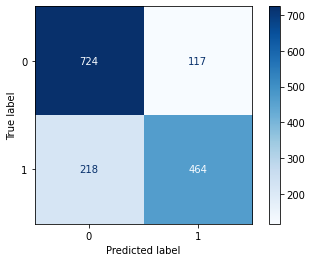

In [37]:
rc =RidgeClassifier()
model0=rc.fit(x_train, y_train)
print("train accuracy:",model0.score(x_train, y_train),"\n","test accuracy:",model0.score(x_test,y_test))

rcpred = rc.predict(x_test)
print("\n")
print("classification report for ridge classifier")
print(classification_report(y_test,rcpred))
print("\n")
print("confusion matrix for ridge classifier")
ConfusionMatrixDisplay.from_estimator(rc, x_test, y_test,cmap="Blues")

train accuracy: 0.9732348111658456 
 test accuracy: 0.7957977675640184


classification report for logistic regression
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       841
           1       0.82      0.70      0.75       682

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.79      1523



confusion matrix for logistic regression


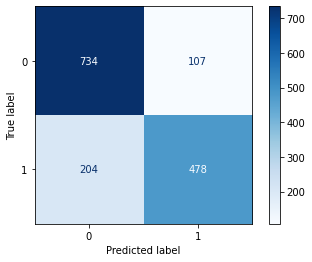

In [38]:
#logistic regression
lr = LogisticRegression(max_iter=2000,penalty='l2')
model1=lr.fit(x_train, y_train)
print("train accuracy:",model1.score(x_train, y_train),"\n","test accuracy:",model1.score(x_test,y_test))
lrpred = lr.predict(x_test)
print("\n")
print("classification report for logistic regression")
print(classification_report(y_test,lrpred))
print("\n")
print("confusion matrix for logistic regression")
ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test,cmap="Blues")

train accuracy: 0.9970443349753695 
 test accuracy: 0.7866053841103086


classification report for support vector machines 
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       841
           1       0.79      0.71      0.75       682

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.78      1523



confusion matrix for support vector machines


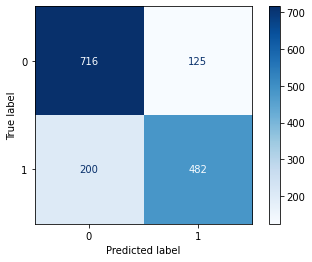

In [39]:
#support vector machines
svm =LinearSVC()
model2=svm.fit(x_train, y_train)
print("train accuracy:",model2.score(x_train, y_train),"\n","test accuracy:",model2.score(x_test,y_test))
svmpred = svm.predict(x_test)
print("\n")
print("classification report for support vector machines ")
print(classification_report(y_test,svmpred))
print("\n")
print("confusion matrix for support vector machines")
ConfusionMatrixDisplay.from_estimator(svm, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7649376231122784


classification report for decision tree classifier
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       841
           1       0.76      0.69      0.73       682

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



confusion matrix for decision tree classifier


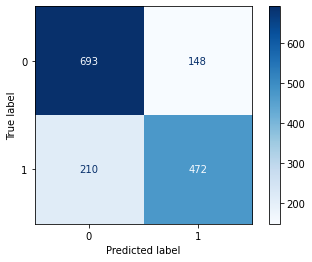

In [40]:
#decision tree classifier
dt=DecisionTreeClassifier()
model3=dt.fit(x_train, y_train)
print("train accuracy:",model3.score(x_train, y_train),"\n","test accuracy:",model3.score(x_test,y_test))

dtpred = dt.predict(x_test)
print("\n")
print("classification report for decision tree classifier")
print(classification_report(y_test,dtpred))
print("\n")
print("confusion matrix for decision tree classifier")
ConfusionMatrixDisplay.from_estimator(dt, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7951411687458962


classification report for random forest classifier
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       841
           1       0.87      0.64      0.74       682

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



confusion matrix for random forest classifier


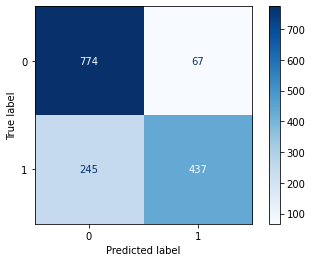

In [41]:
#random forest classifier
rf=RandomForestClassifier(random_state=1234)
model4=rf.fit(x_train, y_train)
print("train accuracy:",model4.score(x_train, y_train),"\n","test accuracy:",model4.score(x_test,y_test))

rfpred = rf.predict(x_test)
print("\n")
print("classification report for random forest classifier")
print(classification_report(y_test,rfpred))
print("\n")
print("confusion matrix for random forest classifier")
ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test,cmap="Blues")

train accuracy: 0.7620689655172413 
 test accuracy: 0.7301378857518056


classification report for gradient boosting classifier
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       841
           1       0.87      0.47      0.61       682

    accuracy                           0.73      1523
   macro avg       0.78      0.71      0.70      1523
weighted avg       0.77      0.73      0.71      1523



confusion matrix for gradient boosting classifier


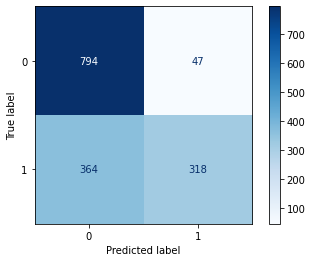

In [42]:
# gradient boost classifier 
gbm=GradientBoostingClassifier()
model5=gbm.fit(x_train, y_train)
print("train accuracy:",model5.score(x_train, y_train),"\n","test accuracy:",model5.score(x_test,y_test))

gbmpred = gbm.predict(x_test)
print("\n")
print("classification report for gradient boosting classifier")
print(classification_report(y_test,gbmpred))
print("\n")
print("confusion matrix for gradient boosting classifier")
ConfusionMatrixDisplay.from_estimator(gbm, x_test, y_test,cmap="Blues")

train accuracy: 0.7619047619047619 
 test accuracy: 0.7393302692055155


classification report for adaboost classifier
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       841
           1       0.82      0.54      0.65       682

    accuracy                           0.74      1523
   macro avg       0.76      0.72      0.72      1523
weighted avg       0.76      0.74      0.73      1523



confusion matrix for adaboost classifier


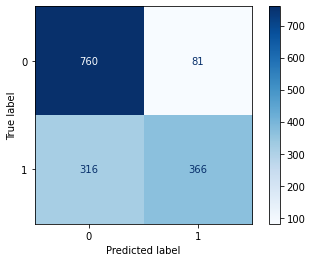

In [43]:
# adaboost classifier 
ada=AdaBoostClassifier()
model6=ada.fit(x_train, y_train)
print("train accuracy:",model6.score(x_train, y_train),"\n","test accuracy:",model6.score(x_test,y_test))

adapred = ada.predict(x_test)
print("\n")
print("classification report for adaboost classifier")
print(classification_report(y_test,adapred))
print("\n")
print("confusion matrix for adaboost classifier")
ConfusionMatrixDisplay.from_estimator(ada, x_test, y_test,cmap="Blues")

train accuracy: 0.8328407224958949 
 test accuracy: 0.7892317793827971


classification report for extreme gradient boosting classifier
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.62      0.73       682

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.78      1523



confusion matrix for extreme gradient boosting classifier


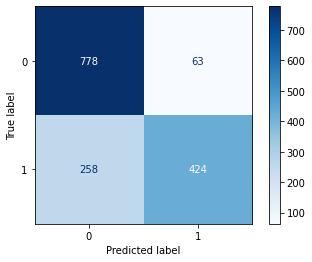

In [44]:
# extreme gradient boost classifier
xgb = XGBClassifier(random_state=1234)
model7=xgb.fit(x_train, y_train)
print("train accuracy:",model7.score(x_train, y_train),"\n","test accuracy:",model7.score(x_test,y_test))
xgbpred = xgb.predict(x_test)
print("\n")
print("classification report for extreme gradient boosting classifier")
print(classification_report(y_test,xgbpred))
print("\n")
print("confusion matrix for extreme gradient boosting classifier")
ConfusionMatrixDisplay.from_estimator(xgb, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7918581746552856


classification report for extra tree classifier
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       841
           1       0.82      0.68      0.75       682

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.79      0.79      1523



confusion matrix for extra tree classifier


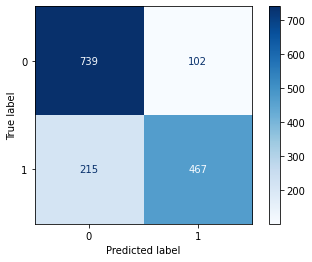

In [45]:
# extra tree classifier
extree = ExtraTreesClassifier()
model8=extree.fit(x_train, y_train)
print("train accuracy:",model8.score(x_train, y_train),"\n","test accuracy:",model8.score(x_test,y_test))

extpred = extree.predict(x_test)
print("\n")
print("classification report for extra tree classifier")
print(classification_report(y_test,extpred))
print("\n")
print("confusion matrix for extra tree classifier")
ConfusionMatrixDisplay.from_estimator(extree, x_test, y_test,cmap="Blues")

train accuracy: 0.9914614121510673 
 test accuracy: 0.8003939592908733


classification report for voting classifier
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       841
           1       0.84      0.68      0.75       682

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



confusion matrix for voting classifier


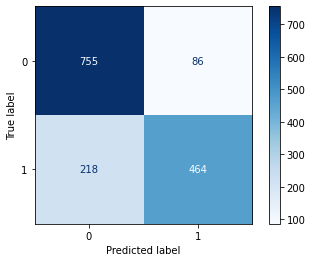

In [46]:
# voting classifer
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier()
clf2 = LogisticRegression(max_iter=2000,penalty='l2')

vc = VotingClassifier(estimators=[('ada', clf1),('lr', clf2)], voting='soft')
model9=vc.fit(x_train, y_train)
print("train accuracy:",model9.score(x_train, y_train),"\n","test accuracy:",model9.score(x_test,y_test))

vcpred = vc.predict(x_test)
print("\n")
print("classification report for voting classifier")
print(classification_report(y_test,vcpred))
print("\n")
print("confusion matrix for voting classifier")
ConfusionMatrixDisplay.from_estimator(vc, x_test, y_test,cmap="Blues")

train accuracy: 0.9927750410509031 
 test accuracy: 0.804333552199606


classification report for stacking classifier
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       841
           1       0.82      0.73      0.77       682

    accuracy                           0.80      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.80      0.80      1523



confusion matrix for stacking classifier


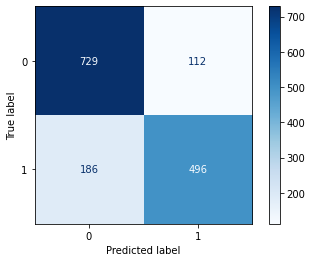

In [47]:
# stacking classifier 
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('rf', RandomForestClassifier()),('ext', make_pipeline(LogisticRegression(max_iter=2000,penalty='l2')))]
sc= StackingClassifier( estimators=estimators)

model10=sc.fit(x_train, y_train)
print("train accuracy:",model10.score(x_train, y_train),"\n","test accuracy:",model10.score(x_test,y_test))

scpred = sc.predict(x_test)
print("\n")
print("classification report for stacking classifier")
print(classification_report(y_test,scpred))
print("\n")
print("confusion matrix for stacking classifier")
ConfusionMatrixDisplay.from_estimator(sc, x_test, y_test,cmap="Blues")

In [48]:
!pip3 install catboost

train accuracy: 0.8392446633825944 
 test accuracy: 0.783322390019698


classification report for cat boost classifier
              precision    recall  f1-score   support

           0       0.75      0.92      0.82       841
           1       0.86      0.61      0.72       682

    accuracy                           0.78      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.80      0.78      0.78      1523



confusion matrix for cat boost classifier


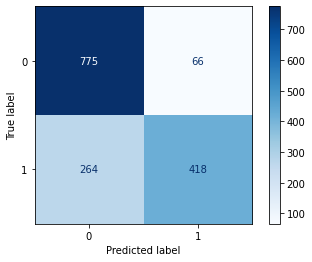

In [49]:
from catboost import CatBoostClassifier

cc = CatBoostClassifier(silent=True )
model11=cc.fit(x_train, y_train)
print("train accuracy:",model11.score(x_train, y_train),"\n","test accuracy:",model11.score(x_test,y_test))

ccpred = cc.predict(x_test)
print("\n")
print("classification report for cat boost classifier")
print(classification_report(y_test,ccpred))
print("\n")
print("confusion matrix for cat boost classifier")
ConfusionMatrixDisplay.from_estimator(cc, x_test, y_test,cmap="Blues")

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
#getting tfidf vlaues for feedback
vectorizertf = TfidfVectorizer()
Xt = vectorizertf.fit_transform(train['text'])

In [52]:
#dividing the dataset to train and test 
xtrain, xtest, ytrain, ytest = train_test_split(Xt, y, test_size=0.2, random_state=1234)

train accuracy: 0.9962233169129721 
 test accuracy: 0.7800393959290873


classification report for ridge classifier
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       841
           1       0.80      0.68      0.73       682

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



confusion matrix for ridge classifier


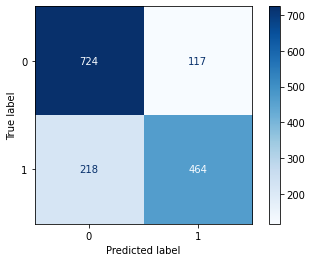

In [53]:
rc =RidgeClassifier()
model0=rc.fit(x_train, y_train)
print("train accuracy:",model0.score(x_train, y_train),"\n","test accuracy:",model0.score(x_test,y_test))

rcpred = rc.predict(x_test)
print("\n")
print("classification report for ridge classifier")
print(classification_report(y_test,rcpred))
print("\n")
print("confusion matrix for ridge classifier")
ConfusionMatrixDisplay.from_estimator(rc, x_test, y_test,cmap="Blues")

train accuracy: 0.9732348111658456 
 test accuracy: 0.7957977675640184


classification report for logistic regression
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       841
           1       0.82      0.70      0.75       682

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.79      1523



confusion matrix for logistic regression


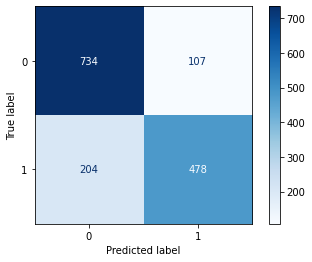

In [54]:
#logistic regression
lr = LogisticRegression(max_iter=2000,penalty='l2')
model1=lr.fit(x_train, y_train)
print("train accuracy:",model1.score(x_train, y_train),"\n","test accuracy:",model1.score(x_test,y_test))
lrpred = lr.predict(x_test)
print("\n")
print("classification report for logistic regression")
print(classification_report(y_test,lrpred))
print("\n")
print("confusion matrix for logistic regression")
ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test,cmap="Blues")

train accuracy: 0.9970443349753695 
 test accuracy: 0.7866053841103086


classification report for support vector machines 
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       841
           1       0.79      0.71      0.75       682

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.78      1523



confusion matrix for support vector machines


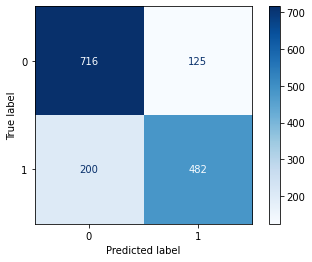

In [55]:
#support vector machines
svm =LinearSVC()
model2=svm.fit(x_train, y_train)
print("train accuracy:",model2.score(x_train, y_train),"\n","test accuracy:",model2.score(x_test,y_test))
svmpred = svm.predict(x_test)
print("\n")
print("classification report for support vector machines ")
print(classification_report(y_test,svmpred))
print("\n")
print("confusion matrix for support vector machines")
ConfusionMatrixDisplay.from_estimator(svm, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7609980302035456


classification report for decision tree classifier
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       841
           1       0.75      0.70      0.73       682

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



confusion matrix for decision tree classifier


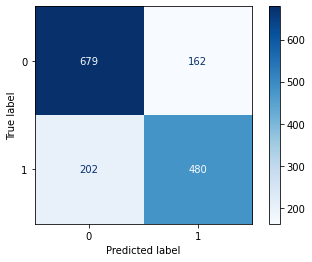

In [56]:
#decision tree classifier
dt=DecisionTreeClassifier()
model3=dt.fit(x_train, y_train)
print("train accuracy:",model3.score(x_train, y_train),"\n","test accuracy:",model3.score(x_test,y_test))

dtpred = dt.predict(x_test)
print("\n")
print("classification report for decision tree classifier")
print(classification_report(y_test,dtpred))
print("\n")
print("confusion matrix for decision tree classifier")
ConfusionMatrixDisplay.from_estimator(dt, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7951411687458962


classification report for random forest classifier
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       841
           1       0.87      0.64      0.74       682

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



confusion matrix for random forest classifier


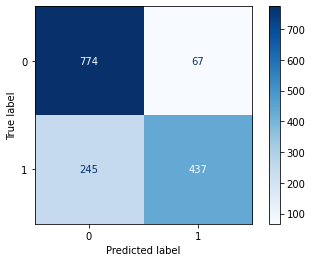

In [57]:
#random forest classifier
rf=RandomForestClassifier(random_state=1234)
model4=rf.fit(x_train, y_train)
print("train accuracy:",model4.score(x_train, y_train),"\n","test accuracy:",model4.score(x_test,y_test))

rfpred = rf.predict(x_test)
print("\n")
print("classification report for random forest classifier")
print(classification_report(y_test,rfpred))
print("\n")
print("confusion matrix for random forest classifier")
ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test,cmap="Blues")

train accuracy: 0.7622331691297208 
 test accuracy: 0.7314510833880499


classification report for gradient boosting classifier
              precision    recall  f1-score   support

           0       0.69      0.94      0.80       841
           1       0.87      0.47      0.61       682

    accuracy                           0.73      1523
   macro avg       0.78      0.71      0.70      1523
weighted avg       0.77      0.73      0.71      1523



confusion matrix for gradient boosting classifier


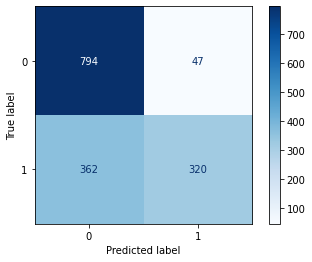

In [58]:
# gradient boost classifier 
gbm=GradientBoostingClassifier()
model5=gbm.fit(x_train, y_train)
print("train accuracy:",model5.score(x_train, y_train),"\n","test accuracy:",model5.score(x_test,y_test))

gbmpred = gbm.predict(x_test)
print("\n")
print("classification report for gradient boosting classifier")
print(classification_report(y_test,gbmpred))
print("\n")
print("confusion matrix for gradient boosting classifier")
ConfusionMatrixDisplay.from_estimator(gbm, x_test, y_test,cmap="Blues")

train accuracy: 0.7619047619047619 
 test accuracy: 0.7393302692055155


classification report for adaboost classifier
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       841
           1       0.82      0.54      0.65       682

    accuracy                           0.74      1523
   macro avg       0.76      0.72      0.72      1523
weighted avg       0.76      0.74      0.73      1523



confusion matrix for adaboost classifier


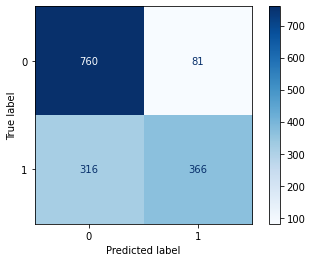

In [59]:
# adaboost classifier 
ada=AdaBoostClassifier()
model6=ada.fit(x_train, y_train)
print("train accuracy:",model6.score(x_train, y_train),"\n","test accuracy:",model6.score(x_test,y_test))

adapred = ada.predict(x_test)
print("\n")
print("classification report for adaboost classifier")
print(classification_report(y_test,adapred))
print("\n")
print("confusion matrix for adaboost classifier")
ConfusionMatrixDisplay.from_estimator(ada, x_test, y_test,cmap="Blues")

train accuracy: 0.8328407224958949 
 test accuracy: 0.7892317793827971


classification report for extreme gradient boosting classifier
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.62      0.73       682

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.78      1523



confusion matrix for extreme gradient boosting classifier


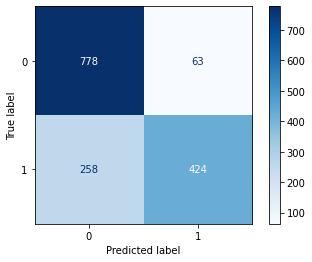

In [60]:
# extreme gradient boost classifier
xgb = XGBClassifier(random_state=1234)
model7=xgb.fit(x_train, y_train)
print("train accuracy:",model7.score(x_train, y_train),"\n","test accuracy:",model7.score(x_test,y_test))
xgbpred = xgb.predict(x_test)
print("\n")
print("classification report for extreme gradient boosting classifier")
print(classification_report(y_test,xgbpred))
print("\n")
print("confusion matrix for extreme gradient boosting classifier")
ConfusionMatrixDisplay.from_estimator(xgb, x_test, y_test,cmap="Blues")

train accuracy: 0.997208538587849 
 test accuracy: 0.7866053841103086


classification report for extra tree classifier
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       841
           1       0.82      0.67      0.74       682

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.78      1523



confusion matrix for extra tree classifier


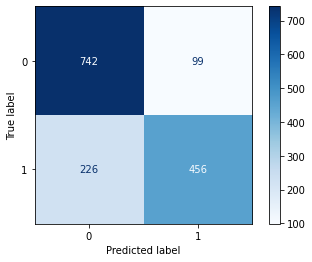

In [61]:
# extra tree classifier
extree = ExtraTreesClassifier()
model8=extree.fit(x_train, y_train)
print("train accuracy:",model8.score(x_train, y_train),"\n","test accuracy:",model8.score(x_test,y_test))

extpred = extree.predict(x_test)
print("\n")
print("classification report for extra tree classifier")
print(classification_report(y_test,extpred))
print("\n")
print("confusion matrix for extra tree classifier")
ConfusionMatrixDisplay.from_estimator(extree, x_test, y_test,cmap="Blues")

train accuracy: 0.9725779967159277 
 test accuracy: 0.7977675640183848


classification report for voting classifier
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       841
           1       0.82      0.70      0.76       682

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



confusion matrix for voting classifier


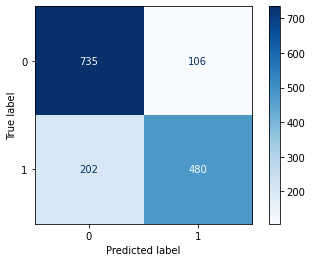

In [62]:
# voting classifer
from sklearn.ensemble import VotingClassifier
clf1 = AdaBoostClassifier()
clf2 = LogisticRegression(max_iter=2000,penalty='l2')

vc = VotingClassifier(estimators=[('ada', clf1),('lr', clf2)], voting='soft')
model9=vc.fit(x_train, y_train)
print("train accuracy:",model9.score(x_train, y_train),"\n","test accuracy:",model9.score(x_test,y_test))

vcpred = vc.predict(x_test)
print("\n")
print("classification report for voting classifier")
print(classification_report(y_test,vcpred))
print("\n")
print("confusion matrix for voting classifier")
ConfusionMatrixDisplay.from_estimator(vc, x_test, y_test,cmap="Blues")

train accuracy: 0.9747126436781609 
 test accuracy: 0.7984241628365069


classification report for stacking classifier
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       841
           1       0.81      0.72      0.76       682

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



confusion matrix for stacking classifier


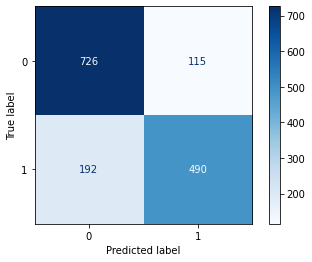

In [63]:
# stacking classifier 
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('ada', AdaBoostClassifier()),('ext', make_pipeline(LogisticRegression(max_iter=2000,penalty='l2')))]
sc= StackingClassifier( estimators=estimators)

model10=sc.fit(x_train, y_train)
print("train accuracy:",model10.score(x_train, y_train),"\n","test accuracy:",model10.score(x_test,y_test))

scpred = sc.predict(x_test)
print("\n")
print("classification report for stacking classifier")
print(classification_report(y_test,scpred))
print("\n")
print("confusion matrix for stacking classifier")
ConfusionMatrixDisplay.from_estimator(sc, x_test, y_test,cmap="Blues")

train accuracy: 0.8392446633825944 
 test accuracy: 0.783322390019698


classification report for cat boost classifier
              precision    recall  f1-score   support

           0       0.75      0.92      0.82       841
           1       0.86      0.61      0.72       682

    accuracy                           0.78      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.80      0.78      0.78      1523



confusion matrix for cat boost classifier


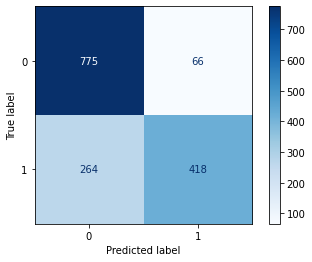

In [64]:
from catboost import CatBoostClassifier

cc = CatBoostClassifier(silent=True )
model11=cc.fit(x_train, y_train)
print("train accuracy:",model11.score(x_train, y_train),"\n","test accuracy:",model11.score(x_test,y_test))

ccpred = cc.predict(x_test)
print("\n")
print("classification report for cat boost classifier")
print(classification_report(y_test,ccpred))
print("\n")
print("confusion matrix for cat boost classifier")
ConfusionMatrixDisplay.from_estimator(cc, x_test, y_test,cmap="Blues")

Stacking classifier with random forest classifier and logistic regression model has the best results for the given problem. The precision, recall and classification accuracy values are higher than all the other models. 